## Project 3 - Polynomial Interpolation

## Introduction

### Project Structure

In [1]:
%ls ..

MATH3316-Project3.xcodeproj/ lib/
bin/                         res/
doc/                         src/


Excluding the `.xcodeproj` file, which was used for integration with the Xcode IDE, debugging, and profiling purposes, each item in the project directory serves the following purpose:

- `Makefile`: GNU Make project build automation definitions.
- `bin/`: compiled binaries. Make will put binaries here by default.
- `doc/`: directory containing all documentation, including this report.
- `lib/`: reused libraries that are not part of this project specifically. Contains a rewrite of the Matrix library ([phrz/matrix](https://github.com/phrz/matrix)).
- `res/`: where calculated data is stored after program execution. Files are `.txt` files containing real numbers, space delimited to denote row items, and newline delimited to denote new rows. For this project, the `.txt` files are also organized into separate `res/part{1..3}/` directories.
- `src/`: contains the C++ implementations of the calculations described in this report.

### Using this Project

#### Prerequisites
- A Unix or Unix-like OS (e.g. macOS or Linux)
- A compiler with support for C++14 (LLVM or GNU toolchain)
- Python ≥3.5
- The latest Jupyter distribution
    - matplotlib
- LaTeX with `pdflatex`
- GNU Make ≥3.81

#### Building this project

`make all` (default) - will compile binaries, execute them to generate data files, execute Jupyter notebooks with new data files, and convert them to PDFs in `res/reports/`.

`make all_bin` - will compile binaries for part 1 and 2 of this project.

`make all_data` - will compile binaries and execute them to generate data files.

`make clean` - will delete all compiled binaries, generated data, executed notebook copies (but not the original notebooks), and report PDFs.

## Part 1 - Newton Form



### Background

#### Newton Form



### Computation and Data




### Analysis



In [68]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
    'font.family': 'Helvetica, Arial, sans-serif'
})

Populating the interactive namespace from numpy and matplotlib


In [69]:
names = [ 'y_real', 'y_comp', 'y_err', ]
data = {name: loadtxt('../res/part1/'+name+'.txt') for name in names}
data['x'] = linspace(-3,3,201) 

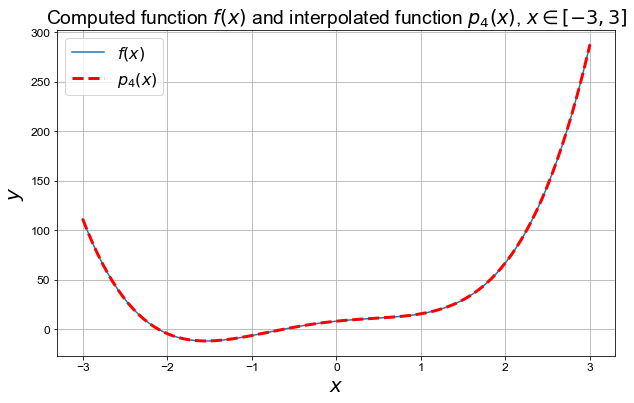

In [70]:
# plot in one figure your interpolating polynomial p_4(x) along with the function f(x)

pylab.plot(data['x'], data['y_real'], linestyle='-')
pylab.plot(data['x'], data['y_comp'], linestyle='--', color='r', linewidth=3)

pylab.title('Computed function $f(x)$ and interpolated function $p_4(x)$, $x \in [-3, 3]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$f(x)$',
              '$p_4(x)$'))

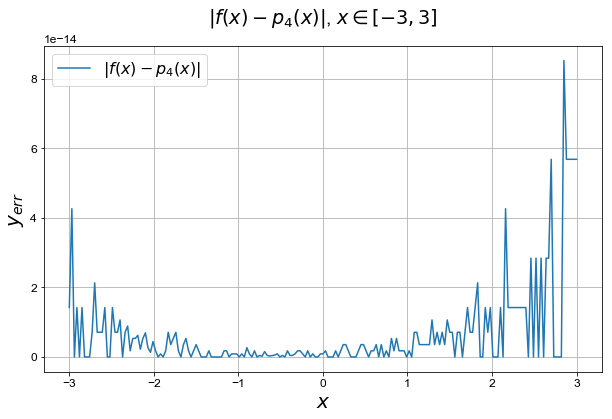

In [71]:
# in another figure, plot the error f(x) − p_4(x) using the same 201 points

pylab.plot(data['x'], data['y_err'])

pylab.title('$|f(x) - p_{4}(x)|$, $x \in [-3, 3]$', y=1.05)
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_4(x)|$',))

### Conclusion



## Part 2 - Effects of Degrees and Nodes



### Background

#### Kepler's Equation



#### Determination of radial position in Keplerian orbit



#### Conversion of polar coordinates to Cartesian coordinates



### Implementation



### Analysis



In [72]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
    'font.family': 'Helvetica, Arial, sans-serif'
})

Populating the interactive namespace from numpy and matplotlib


In [73]:
names = [ 'y_real10', 'y_comp10', 'y_err10', 'y_real20', 'y_comp20', 'y_err20', 'omega10', 'omega20' ]
data = {name: loadtxt('../res/part2/function/'+name+'.txt') for name in names}
data['n_10'] = linspace(-5,5,11)
data['n_20'] = linspace(-5,5,21)
data['x_10'] = linspace(-5,5,401)
data['x_20'] = linspace(-5,5,401)

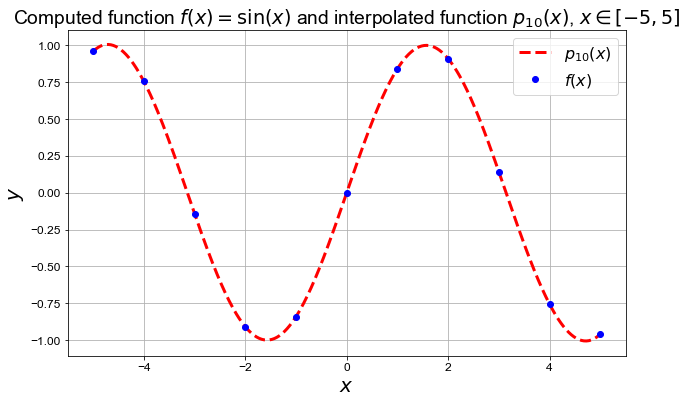

In [74]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 10

pylab.plot(data['x_10'], data['y_comp10'], linestyle='--', color='r', linewidth=3)

y_real = data['y_real10']
for i in range(len(y_real)):
    pylab.plot(data['n_10'][i], y_real[i], 'bo')

pylab.title('Computed function $f(x) = \sin(x)$ and interpolated function $p_{10}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{10}(x)$',
              '$f(x)$'))

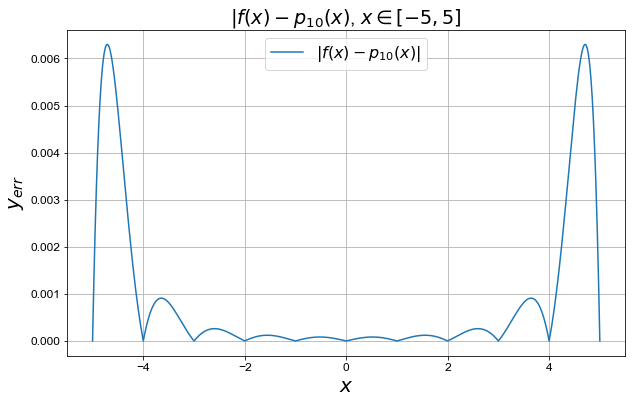

In [75]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_10'], data['y_err10'])

pylab.title('$|f(x) - p_{10}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{10}(x)|$',))

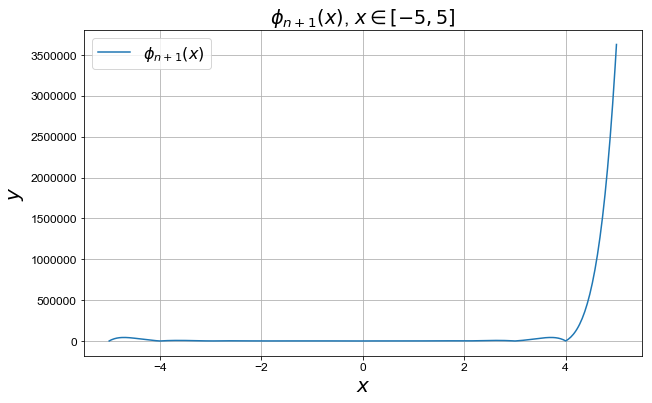

In [76]:
# plot in your report the graphs of phi_{n+1}(x) for
# the (n + 1) = 11 equally distributed nodes

pylab.plot(data['x_10'], data['omega10'])

pylab.title('$\phi_{n+1}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$\phi_{n+1}(x)$',))

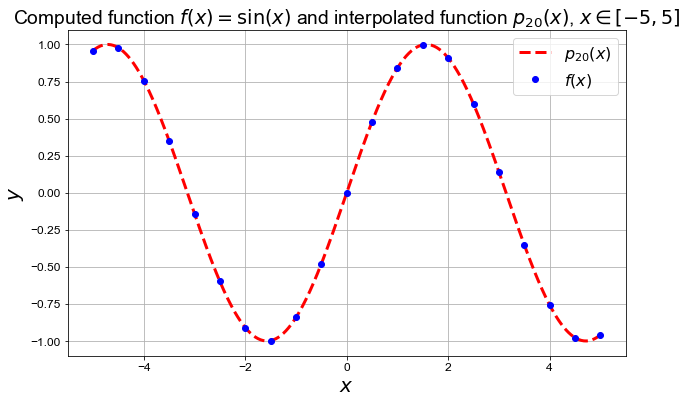

In [261]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 20

pylab.plot(data['x_20'], data['y_comp20'], linestyle='--', color='r', linewidth=3)

y_real = data['y_real20']
for i in range(len(y_real)):
    pylab.plot(data['n_20'][i], y_real[i], 'bo')

pylab.title('Computed function $f(x) = \sin(x)$ and interpolated function $p_{20}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{20}(x)$',
              '$f(x)$'))

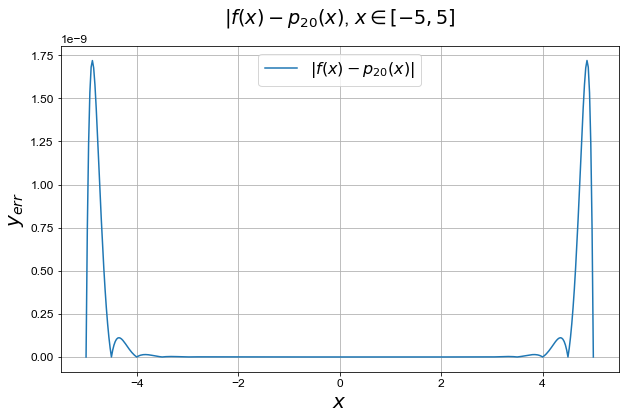

In [262]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_20'], data['y_err20'])

pylab.title('$|f(x) - p_{20}(x)$, $x \in [-5, 5]$', y=1.05)
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{20}(x)|$',))

In [264]:
names = [ 'runge_uniform_real10', 'runge_uniform_comp10', 'runge_uniform_err10', 'runge_uniform_real20', 'runge_uniform_comp20', 'runge_uniform_err20' ]
data = {name: loadtxt('../res/part2/runge_uniform/'+name+'.txt') for name in names}
data['n_10'] = linspace(-5,5,11)
data['n_20'] = linspace(-5,5,21)
data['x_10'] = linspace(-5,5,401)
data['x_20'] = linspace(-5,5,401)

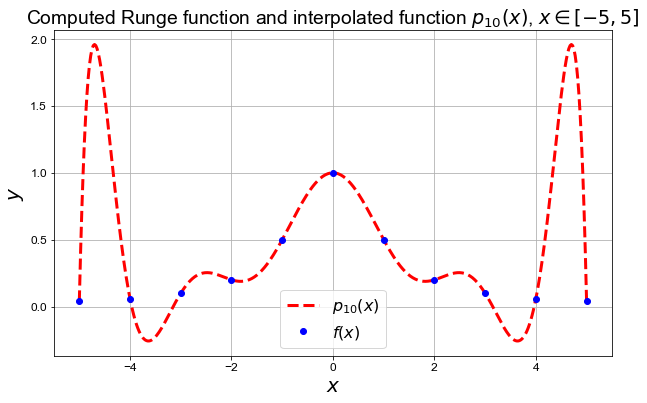

In [265]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 10

pylab.plot(data['x_10'], data['runge_uniform_comp10'], linestyle='--', color='r', linewidth=3)

y_real = data['runge_uniform_real10']
for i in range(len(y_real)):
    pylab.plot(data['n_10'][i], y_real[i], 'bo')

pylab.title('Computed Runge function and interpolated function $p_{10}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{10}(x)$',
              '$f(x)$'))

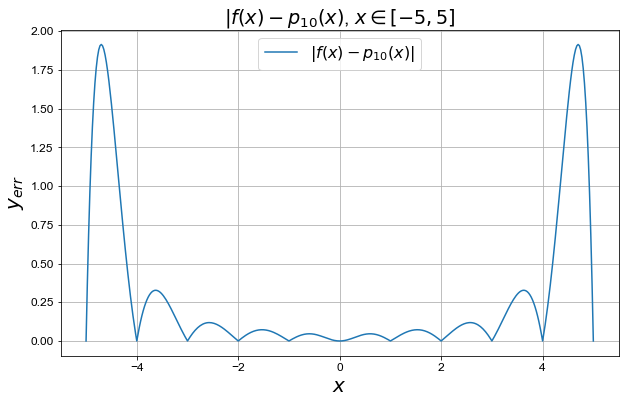

In [266]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_10'], data['runge_uniform_err10'])

pylab.title('$|f(x) - p_{10}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{10}(x)|$',))

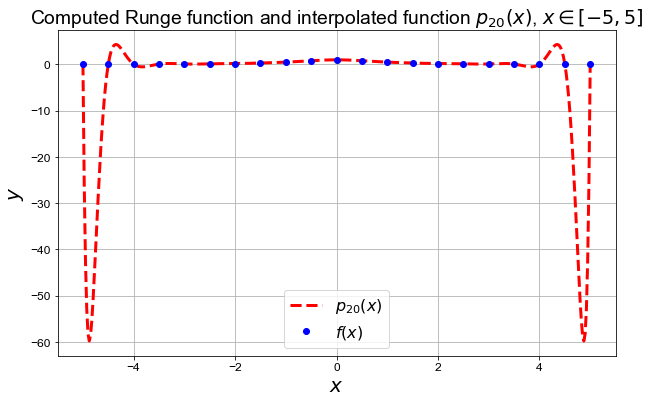

In [267]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 20

pylab.plot(data['x_20'], data['runge_uniform_comp20'], linestyle='--', color='r', linewidth=3)

y_real = data['runge_uniform_real20']
for i in range(len(y_real)):
    pylab.plot(data['n_20'][i], y_real[i], 'bo')

pylab.title('Computed Runge function and interpolated function $p_{20}(x)$, $x \in [-5, 5]$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{20}(x)$',
              '$f(x)$'))

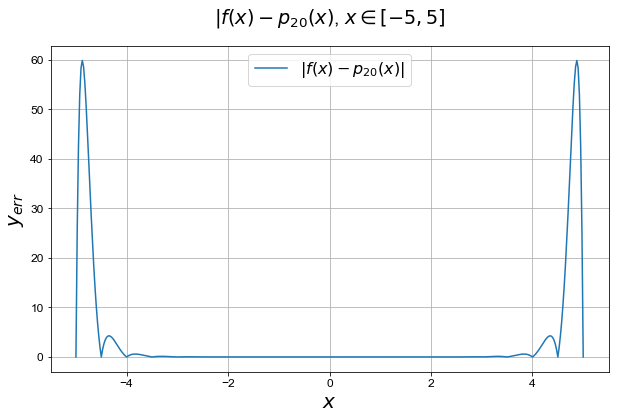

In [268]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_20'], data['runge_uniform_err20'])

pylab.title('$|f(x) - p_{20}(x)$, $x \in [-5, 5]$', y=1.05)
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{20}(x)|$',))

In [50]:
names = [ 'runge_Chebyshev_real10', 'runge_Chebyshev_comp10', 'runge_Chebyshev_err10', \
          'runge_Chebyshev_real20', 'runge_Chebyshev_comp20', 'runge_Chebyshev_err20', \
          'runge_Chebyshev_nodes10', 'runge_Chebyshev_nodes20', 'runge_Chebyshev_omega10' ]
data = {name: loadtxt('../res/part2/runge_chebyshev/'+name+'.txt') for name in names}
data['n_10'] = linspace(-5,5,11)
data['n_20'] = linspace(-5,5,21)
data['x_10'] = linspace(-5,5,401)
data['x_20'] = linspace(-5,5,401)

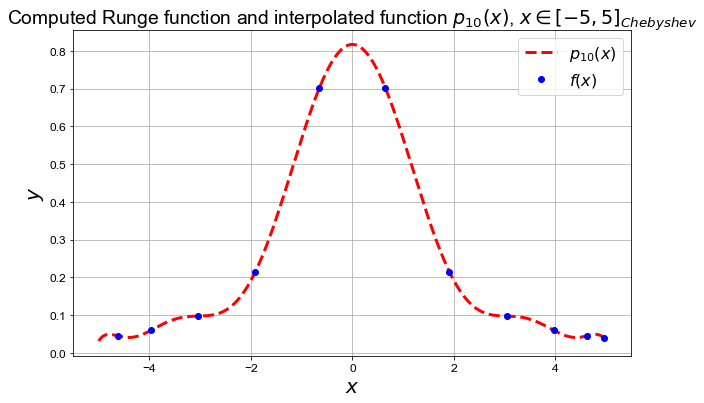

In [51]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 10

pylab.plot(data['x_10'], data['runge_Chebyshev_comp10'], linestyle='--', color='r', linewidth=3)

y_real = data['runge_Chebyshev_real10']
for i in range(len(y_real)):
    pylab.plot(data['runge_Chebyshev_nodes10'][i], y_real[i], 'bo')

pylab.title('Computed Runge function and interpolated function $p_{10}(x)$, $x \in [-5, 5]_{Chebyshev}$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{10}(x)$',
              '$f(x)$'))

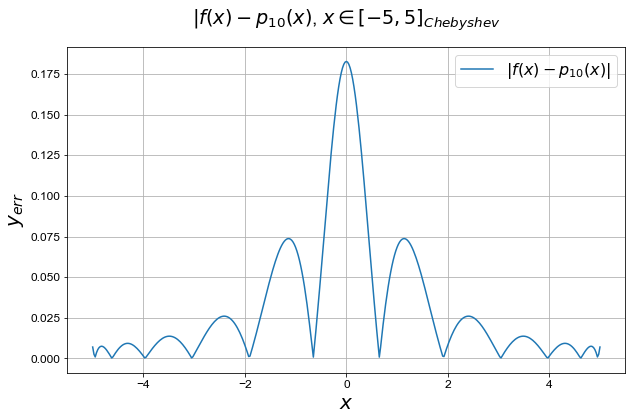

In [52]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_10'], data['runge_Chebyshev_err10'])

pylab.title('$|f(x) - p_{10}(x)$, $x \in [-5, 5]_{Chebyshev}$', y=1.05)
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{10}(x)|$',))

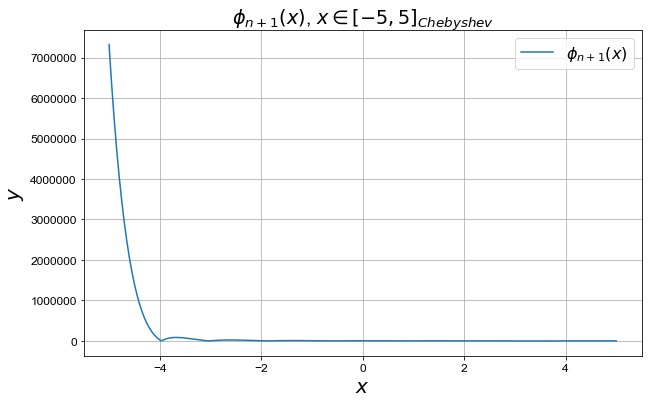

In [53]:
# plot in your report the graphs of phi_{n+1}(x) for
# the 11 Chebyshev nodes

pylab.plot(data['x_10'], data['runge_Chebyshev_omega10'])

pylab.title('$\phi_{n+1}(x)$, $x \in [-5, 5]_{Chebyshev}$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$\phi_{n+1}(x)$',))

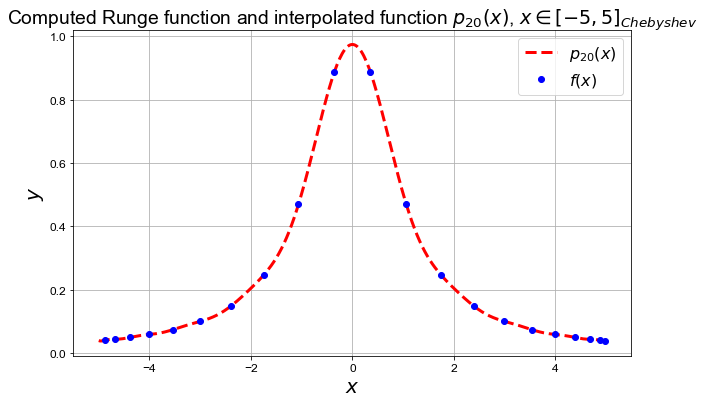

In [273]:
# plot the interpolating polynomial p_n(x) and the data generating function f(x) in the same figure
# here, n = 10

pylab.plot(data['x_10'], data['runge_Chebyshev_comp20'], linestyle='--', color='r', linewidth=3)

y_real = data['runge_Chebyshev_real20']
for i in range(len(y_real)):
    pylab.plot(data['runge_Chebyshev_nodes20'][i], y_real[i], 'bo')

pylab.title('Computed Runge function and interpolated function $p_{20}(x)$, $x \in [-5, 5]_{Chebyshev}$')
pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.grid()

pylab.legend(('$p_{20}(x)$',
              '$f(x)$'))

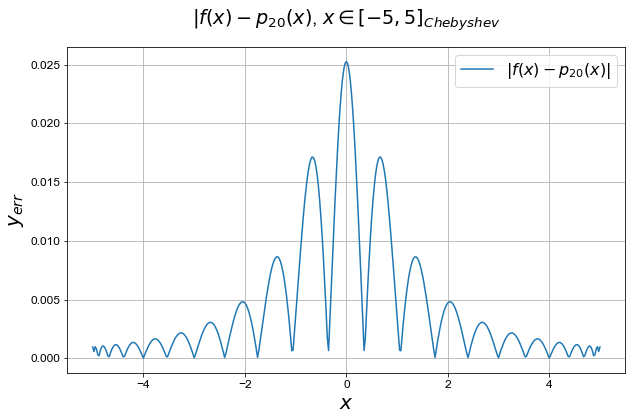

In [274]:
# plot the error f(x) − p_n(x) in another figure

pylab.plot(data['x_20'], data['runge_Chebyshev_err20'])

pylab.title('$|f(x) - p_{20}(x)$, $x \in [-5, 5]_{Chebyshev}$', y=1.05)
pylab.xlabel('$x$')
pylab.ylabel('$y_{err}$')
pylab.grid()

pylab.legend(('$|f(x) - p_{20}(x)|$',))

## Part 3 - Application



### Background



### Implementation



### Analysis

#### Part A

In [246]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
    'font.family': 'Helvetica, Arial, sans-serif'
})

Populating the interactive namespace from numpy and matplotlib


In [247]:
names = [ 'years', 'temps', 'comp', ]
data = {name: loadtxt('../res/part3/'+name+'.txt') for name in names}
data['x'] = linspace(1885,1995,200) 

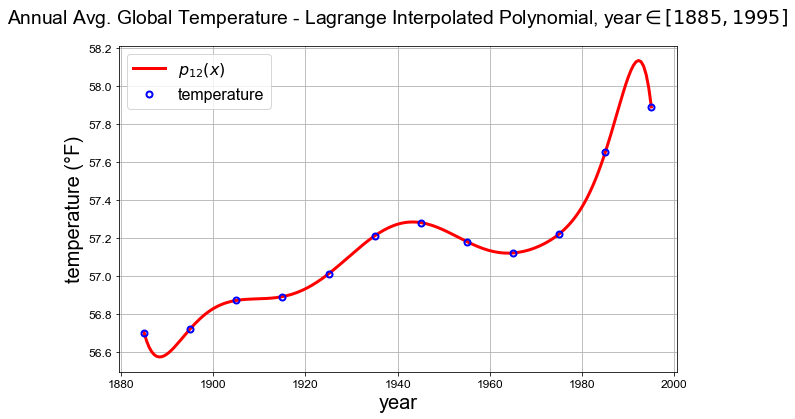

In [249]:
# Plot the interpolating polynomial through this data using 200 points
# in the interval [1885, 1995] with a solid line. On the same plot, overlay
# the data values as open circles.

pylab.plot(data['x'], data['comp'], color='r', linewidth=3)

y_real = data['temps']
for i in range(len(y_real)):
    pylab.plot(data['years'][i], y_real[i], 'bo', markeredgewidth=2, markerfacecolor='none')

pylab.title('Annual Avg. Global Temperature - Lagrange Interpolated Polynomial, year$\in [1885, 1995]$', y=1.05)
pylab.xlabel('year')
pylab.ylabel('temperature (°F)')
pylab.grid()

pylab.legend(('$p_{12}(x)$',
              'temperature'))

#### Part B

Predict the average global temperature for the years:

* 1903 (first flight by the Wright brothers)
* 1941 (attack on Pearl Harbor)
* 1963 (JFK assassination)
* 1969 (moon landing)
* 1976 (first Apple computer)
* 1989 (fall of the Berlin wall)
* 1999 (Columbine shootings)
* 2009 (discovery of water on moon)
* 2015

In [236]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
    'font.family': 'Helvetica, Arial, sans-serif'
})

Populating the interactive namespace from numpy and matplotlib


In [237]:
names = [ 'predict_years', 'predict_temps' ]
data = {name: loadtxt('../res/part3/'+name+'.txt') for name in names}

data['predict_years'] = list(map(int, data['predict_years']))
data['predict_temps'] = [f"{x:.2f}" for x in data['predict_temps']]
data['actual_temps'] = [56.71, 57.40, 57.25, 57.20, 56.79, 57.69, 57.97, 58.50, 58.62]
data['temp_deltas'] = [float(x) - y for x,y in zip(data['predict_temps'], data['actual_temps'])]
data['temp_deltas'] = [f"{x:.2f}" for x in data['temp_deltas']]

print(data['temp_deltas'])

['0.15', '-0.12', '-0.13', '-0.06', '0.45', '0.28', '-2.27', '-48.92', '-171.83']


In [238]:
from IPython.display import (HTML, display)

table = [ data['predict_years'], data['predict_temps'] ]

table[0] = np.hstack(('Year', table[0]))
table[1] = np.hstack(('Predicted Temperature (ºF)', table[1]))

table = zip(*table)

display(HTML('<h5>Predicted Temperatures for Given Years using Lagrangian interpolation<h5>'))
display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table)
        )
 ))

Year,Predicted Temperature (ºF)
1903,56.86
1941,57.28
1963,57.12
1969,57.14
1976,57.24
1989,57.97
1999,55.70
2009,9.58
2015,-113.21


#### Part C

In [239]:
from IPython.display import (HTML, display)

table = [ data['predict_years'], data['predict_temps'], data['actual_temps'], data['temp_deltas'] ]

table[0] = np.hstack(('Year', table[0]))
table[1] = np.hstack(('Predicted Temperature (ºF)', table[1]))
table[2] = np.hstack(('Actual Temperature (ºF)', table[2]))
table[3] = np.hstack(('$\Delta$ Temperature', table[3]))

table = zip(*table)

display(HTML('<h5>Predicted Temperatures for Given Years using Lagrangian interpolation<h5>'))
display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in table)
        )
 ))

Year,Predicted Temperature (ºF),Actual Temperature (ºF),$\Delta$ Temperature
1903,56.86,56.71,0.15
1941,57.28,57.4,-0.12
1963,57.12,57.25,-0.13
1969,57.14,57.2,-0.06
1976,57.24,56.79,0.45
1989,57.97,57.69,0.28
1999,55.70,57.97,-2.27
2009,9.58,58.5,-48.92
2015,-113.21,58.62,-171.83


#### Part D

In [251]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
    'font.family': 'Helvetica, Arial, sans-serif'
})

Populating the interactive namespace from numpy and matplotlib


In [252]:
names = [ 'years', 'temps', 'comp_extended', ]
data = {name: loadtxt('../res/part3/'+name+'.txt') for name in names}
data['x'] = linspace(1885,2015,200)

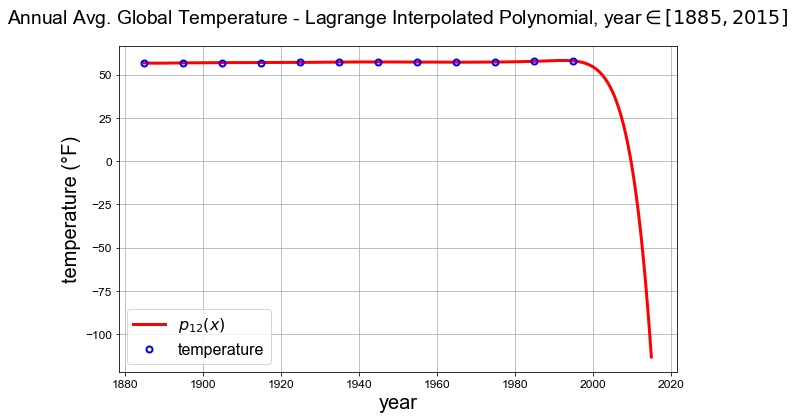

In [254]:
# Plot the interpolating polynomial through this data using 200 points
# in the interval [1885, 2015] with a solid line. On the same plot, overlay
# the data values as open circles.

pylab.plot(data['x'], data['comp_extended'], color='r', linewidth=3)

y_real = data['temps']
for i in range(len(y_real)):
    pylab.plot(data['years'][i], y_real[i], 'bo', markeredgewidth=2, markerfacecolor='none')

pylab.title('Annual Avg. Global Temperature - Lagrange Interpolated Polynomial, year$\in [1885, 2015]$', y=1.05)
pylab.xlabel('year')
pylab.ylabel('temperature (°F)')
pylab.grid()

pylab.legend(('$p_{12}(x)$',
              'temperature'))